# BERT Prediction Error Analysis

As the result of text classification by 3 types of BERT models ( BERT_BASED_UNCASED, BERT_LARGE_UNCASED, DISTILBERT), it is found that:
 - The smaller the model is, the higher the accuracies. Distilbert achieved 77.8% in contrast that Bert_large_uncased only achieved 70& around.

In order to improve the accuracy level, we will perform the further study on those records whose prediction result are wrong, and see whether there are some ways.

Given Bert_large_uncased does not achieved high accuracy, in order to save the potential efforts, we take the remaining 2 models for the error analysis.

In [1]:
import warnings
# Disable 3 types of warning
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=(FutureWarning))
warnings.filterwarnings("ignore",category=(RuntimeWarning))

In [2]:
import torch
#Enable GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

RANDOM_STATE=1
#################### split data into train,dev,test##################
def train_dev_test(dataset,random_state=RANDOM_STATE):
    texts=list(dataset["original_text"])
    labels=list(dataset["label"])
    
    target_names = list(set(labels))
    label2idx = {label: idx for idx, label in enumerate(target_names)}
    print(label2idx)

    rest_texts, test_texts, rest_labels, test_labels = train_test_split(texts, labels, test_size=0.1, random_state=1)
    train_texts, dev_texts, train_labels, dev_labels = train_test_split(rest_texts, rest_labels, test_size=0.1, random_state=1)

    print("Train size:", len(train_texts))
    print("Dev size:", len(dev_texts))
    print("Test size:", len(test_texts))
    return (train_texts,dev_texts,test_texts),(train_labels,dev_labels,test_labels),(target_names,label2idx)

In [4]:
import logging

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

In [5]:
import numpy as np
#################### Both class and the following function are used to prepare for input items##################

class BertInputItem(object):
    """An item with all the necessary attributes for finetuning BERT."""

    def __init__(self, text, input_ids, input_mask, segment_ids, label_id):
        self.text = text
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id
        

def convert_examples_to_inputs(example_texts, example_labels, label2idx, max_seq_length, tokenizer):
    """Loads a data file into a list of `InputBatch`s."""
    
    input_items = []
    examples = zip(example_texts, example_labels)
    for (ex_index, (text, label)) in enumerate(examples):

        # Create a list of token ids
        input_ids = tokenizer.encode(f"[CLS] {text} [SEP]")
        if len(input_ids) > max_seq_length:
            input_ids = input_ids[:max_seq_length]

        # All our tokens are in the first input segment (id 0).
        segment_ids = [0] * len(input_ids)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        label_id = label2idx[label]

        input_items.append(
            BertInputItem(text=text,
                          input_ids=input_ids,
                          input_mask=input_mask,
                          segment_ids=segment_ids,
                          label_id=label_id))

        
    return input_items


In [6]:
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

#################### convert data for model input ##################

def get_data_loader(features, max_seq_length, batch_size, shuffle=True): 

    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
    all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
    all_label_ids = torch.tensor([f.label_id for f in features], dtype=torch.long)
    data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)

    #dataloader = DataLoader(data, shuffle=shuffle, batch_size=batch_size)
    # dataloader tuning in https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html
   
    dataloader = DataLoader(data, shuffle=shuffle, batch_size=batch_size,num_workers=2,pin_memory=True)
    return dataloader

In [7]:
from tqdm import trange
from tqdm.notebook import tqdm

def evaluate(model, dataloader):
    model.eval()
    
    eval_loss = 0
    nb_eval_steps = 0
    predicted_labels, correct_labels = [], []

    for step, batch in enumerate(tqdm(dataloader, desc="Evaluation iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch

        with torch.no_grad():
            #tmp_eval_loss, logits = model(input_ids, attention_mask=input_mask,
            #                              token_type_ids=segment_ids, labels=label_ids)[:2]
            tmp_eval_loss, logits = model(input_ids, attention_mask=input_mask,
                                         labels=label_ids)[:2]  # for distilbert
        outputs = np.argmax(logits.to('cpu'), axis=1)
        label_ids = label_ids.to('cpu').numpy()
        
        predicted_labels += list(outputs)
        correct_labels += list(label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    
    correct_labels = np.array(correct_labels)
    predicted_labels = np.array(predicted_labels)
        
    return eval_loss, correct_labels, predicted_labels

In [8]:
import os
from tqdm import trange
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, precision_recall_fscore_support
from transformers import AdamW,get_linear_schedule_with_warmup


def train(model_name,train_texts,train_labels,dev_texts,dev_labels,target_names,label2idx,params):
    
    
    ## Initialize bert model   
    tokenizer = DistilBertTokenizer.from_pretrained(model_name,target_names=target_names)
    # Using trained model
    model=DistilBertForSequenceClassification.from_pretrained(model_name,num_labels = len(target_names),
                                                             output_attentions = False,
                                                             output_hidden_states = False)  
    
    ## Prepare for data loading and parameter setting for bert model
    train_features = convert_examples_to_inputs(train_texts,train_labels, label2idx, params['MAX_SEQ_LENGTH'], tokenizer)
    train_dataloader = get_data_loader(train_features, params['MAX_SEQ_LENGTH'], params['BATCH_SIZE'], shuffle=True)
    dev_features = convert_examples_to_inputs(dev_texts,dev_labels, label2idx, params['MAX_SEQ_LENGTH'], tokenizer)
    dev_dataloader = get_data_loader(dev_features, params['MAX_SEQ_LENGTH'], params['BATCH_SIZE'], shuffle=True)

    num_train_steps = int(len(train_dataloader.dataset) / params['BATCH_SIZE'] /params['GRADIENT_ACCUMULATION_STEPS'] * params['NUM_TRAIN_EPOCHS'])
    num_warmup_steps = params['NUM_WARMUP_STEPS']

    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]

    optimizer = AdamW(optimizer_grouped_parameters, lr=params['LEARNING_RATE'], correct_bias=False)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps,num_training_steps=num_train_steps)
    
    ##Enable GPU if has
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    ## Start to training 
    torch.backends.cudnn.benchmark = True # tuning guide:https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html

    loss_history = []
    no_improvement = 0
    PATIENCE=2
    for _ in trange(int(params["NUM_TRAIN_EPOCHS"]), desc="Epoch"):
        model.train()
        tr_loss = 0
        nb_tr_examples, nb_tr_steps = 0, 0

        for step, batch in enumerate(tqdm(train_dataloader, desc="Training iteration")):
            batch = tuple(t.to(device) for t in batch)
            input_ids, input_mask, segment_ids, label_ids = batch
            #outputs = model(input_ids, attention_mask=input_mask, token_type_ids=segment_ids, labels=label_ids) # non-distillbert
            outputs = model(input_ids, attention_mask=input_mask,labels=label_ids)
            loss = outputs[0]

            if params['GRADIENT_ACCUMULATION_STEPS'] > 1:
                loss = loss / params['GRADIENT_ACCUMULATION_STEPS']

            loss.backward()
            tr_loss += loss.item()

            if (step + 1) % params['GRADIENT_ACCUMULATION_STEPS'] == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(),params['MAX_GRAD_NORM'])  

                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                scheduler.step()
        dev_loss, _, _ = evaluate(model, dev_dataloader)
            #print("Dev loss:", dev_loss)
    
        print("Loss history:", loss_history)
        print("Dev loss:", dev_loss)

        if len(loss_history) == 0 or dev_loss < min(loss_history):
            no_improvement = 0
            model_to_save = model.module if hasattr(model, 'module') else model
            output_model_file = os.path.join(OUTPUT_DIR, MODEL_FILE_NAME)
            torch.save(model_to_save.state_dict(), output_model_file)
        else:
            no_improvement += 1

        if no_improvement >= PATIENCE: 
            print("No improvement on development set. Finish training.")
            break


        loss_history.append(dev_loss)
    

In [9]:
from transformers import BertForSequenceClassification,DistilBertForSequenceClassification
from transformers import BertTokenizer,DistilBertTokenizer
import os
from sklearn.metrics import classification_report, precision_recall_fscore_support

OUTPUT_DIR = "./tmp/"
MODEL_FILE_NAME = "pytorch_model.bin"


# Evaluate the dataset based on trained distilbert model
def data_evaluation(texts,labels,model_name,params,trained=True,OUTPUT_DIR = OUTPUT_DIR, MODEL_FILE_NAME = MODEL_FILE_NAME):
    # Convert test data of submission to features
    target_names = list(set(labels))
    label2idx = {label: idx for idx, label in enumerate(target_names)}
    
    # Enable GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Select bert model
    #BERT_MODEL = "distilbert-base-uncased"
    tokenizer = DistilBertTokenizer.from_pretrained(model_name)
       
    if trained:
        # Using trained model
        model_state_dict = torch.load(os.path.join(OUTPUT_DIR, MODEL_FILE_NAME), map_location=lambda storage, loc: storage)
        model=DistilBertForSequenceClassification.from_pretrained(model_name, state_dict=model_state_dict, num_labels = len(target_names),
                                                                 output_attentions = False,
                                                                 output_hidden_states = False)
    else:
        # Using pretrained model without training
        model=DistilBertForSequenceClassification.from_pretrained(BERT_MODEL,num_labels = len(target_names),
                                                                 output_attentions = False,
                                                                 output_hidden_states = False)        
    model.to(device)
    
    # Convert text and labels to embeddings 
    features = convert_examples_to_inputs(texts, labels, label2idx,  params['MAX_SEQ_LENGTH'], tokenizer)
    dataloader = get_data_loader(features, params['MAX_SEQ_LENGTH'], params['BATCH_SIZE'], shuffle=False)
    
    # Predict the result, and discard the evaluatoin result, only take the prediction result.
    _, correct, predicted = evaluate(model, dataloader)
    print("Errors performance:", precision_recall_fscore_support(correct, predicted, average="micro"))

    bert_accuracy = np.mean(predicted == correct)
    
    #print(bert_accuracy)
    print(classification_report(correct, predicted))

    return correct,predicted, bert_accuracy 

##### Import dataset

In [10]:
import pandas as pd
# load train data
source_train_data_path="./01_data/WikiLarge_Train.csv"
source_train_data=pd.read_csv(source_train_data_path)

RANDOM_STATE=1
PORTION=0.01
size=round(len(source_train_data)*PORTION)
train_data=source_train_data.sample(n=size,random_state=RANDOM_STATE)

Text(0.5, 0, 'length')

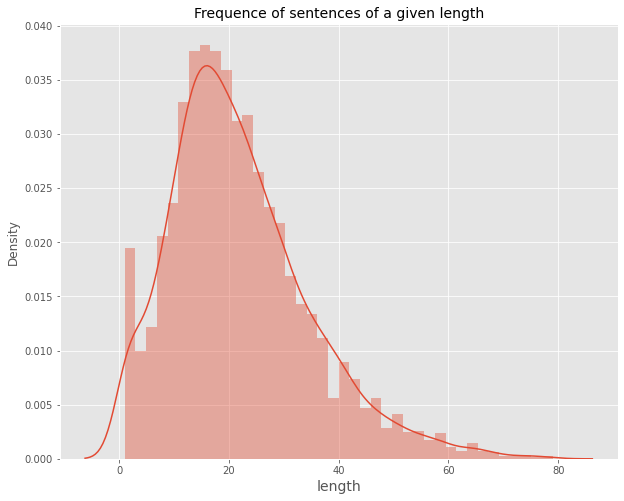

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot histogram with the length. Truncate max length to 5000 tokens.
plt.style.use("ggplot")

plt.figure(figsize=(10, 8))
train_data['length'] = train_data['original_text'].apply(lambda x: len(x.split()))
sns.distplot(train_data[train_data['length'] < 5000]['length'])
plt.title('Frequence of sentences of a given length', fontsize=14)
plt.xlabel('length', fontsize=14)

In [12]:
# BERT token length should not be more than 512.
data_describe=train_data['original_text'].apply(lambda x: len(x.split())).describe()
print(data_describe)
MAX_SEQ_LENGTH=int(data_describe['max'])
if MAX_SEQ_LENGTH>512:
    MAX_SEQ_LENGTH=512

count    4168.000000
mean       21.913628
std        12.775337
min         1.000000
25%        13.000000
50%        20.000000
75%        29.000000
max        79.000000
Name: original_text, dtype: float64


In [13]:

(train_texts,dev_texts,test_texts),(train_labels,dev_labels,test_labels),(target_names,label2idx)=train_dev_test(train_data,random_state=RANDOM_STATE)

{0: 0, 1: 1}
Train size: 3375
Dev size: 376
Test size: 417


In [14]:
params={
        "GRADIENT_ACCUMULATION_STEPS":1,
        "NUM_TRAIN_EPOCHS":8,
        "LEARNING_RATE":2e-5,
        "WARMUP_PROPORTION":0.1,
        "MAX_GRAD_NORM":5,
        "MAX_SEQ_LENGTH":MAX_SEQ_LENGTH,
        "BATCH_SIZE":16,
        "NUM_WARMUP_STEPS":600
}
BERT_MODEL = "distilbert-base-uncased"

##### Initial accuracy for pretrain model

In [15]:
_,_,init_acc=data_evaluation(test_texts,test_labels,BERT_MODEL,params,trained=False,OUTPUT_DIR = OUTPUT_DIR, MODEL_FILE_NAME = MODEL_FILE_NAME)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

Evaluation iteration:   0%|          | 0/27 [00:00<?, ?it/s]

Errors performance: (0.5227817745803357, 0.5227817745803357, 0.5227817745803357, None)
              precision    recall  f1-score   support

           0       0.41      0.04      0.07       196
           1       0.53      0.95      0.68       221

    accuracy                           0.52       417
   macro avg       0.47      0.50      0.37       417
weighted avg       0.47      0.52      0.39       417



##### Train model without any preprocessing.

In [16]:
train(BERT_MODEL,train_texts,train_labels,dev_texts,dev_labels,target_names,label2idx,params)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.6223116430143515


Epoch:  12%|█████████▋                                                                   | 1/8 [00:40<04:44, 40.63s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  25%|███████████████████▎                                                         | 2/8 [01:20<04:00, 40.14s/it]

Loss history: [0.6223116430143515]
Dev loss: 0.6304677041868368


Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  25%|███████████████████▎                                                         | 2/8 [02:00<06:00, 60.10s/it]

Loss history: [0.6223116430143515, 0.6304677041868368]
Dev loss: 0.6753258295357227
No improvement on development set. Finish training.


##### Accuracy after training

In [17]:
_,_,orig_acc=data_evaluation(test_texts,test_labels,BERT_MODEL,params,trained=True,OUTPUT_DIR = OUTPUT_DIR, MODEL_FILE_NAME = MODEL_FILE_NAME)

Evaluation iteration:   0%|          | 0/27 [00:00<?, ?it/s]

Errors performance: (0.6666666666666666, 0.6666666666666666, 0.6666666666666666, None)
              precision    recall  f1-score   support

           0       0.64      0.67      0.65       196
           1       0.69      0.67      0.68       221

    accuracy                           0.67       417
   macro avg       0.67      0.67      0.67       417
weighted avg       0.67      0.67      0.67       417



##### Remove stopwords

In [18]:
from text_preprocessing import preprocess_text
from text_preprocessing import remove_punctuation,remove_special_character,normalize_unicode,check_spelling,remove_stopword,lemmatize_word
# Preprocess text using custom preprocess functions in the pipeline 
#STOPWORDS=['-RRB-','-LRB-'] # remove customized stopwords
#preprocess_functions = [to_lower, remove_punctuation,remove_special_character,normalize_unicode,remove_stopword,lemmatize_word]


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\patri\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [19]:
process_data=train_data.copy()
process_data['original_text'] = process_data['original_text'].apply(lambda x:' '.join(remove_stopword(x)))

In [20]:
process_data

,original_text,label,length
314316,"The Yarra Trams fleet consists 500 trams , ope...",0,18
136396,"Still Life concept album , explained Åkerfeldt...",1,39
377680,"Romana , short Romanadvoratrelundar , fictiona...",0,20
280270,A minor scale music theory scale least three s...,0,35
285587,The show also created character Frasier Crane .,0,9
...,...,...,...
145077,"In paintball , bunker obstacle field play used...",1,25
35542,La Ferrière-Harang commune Calvados department...,1,17
238435,The British Rail Class 325 dual-voltage altern...,0,26
324621,When Palmengarten returned city 's control 196...,0,21


In [21]:
(train_texts,dev_texts,test_texts),(train_labels,dev_labels,test_labels),(target_names,label2idx)=train_dev_test(process_data,random_state=RANDOM_STATE)

{0: 0, 1: 1}
Train size: 3375
Dev size: 376
Test size: 417


In [22]:
train(BERT_MODEL,train_texts,train_labels,dev_texts,dev_labels,target_names,label2idx,params)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.6449858819444975


Epoch:  12%|█████████▋                                                                   | 1/8 [00:40<04:43, 40.53s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: [0.6449858819444975]
Dev loss: 0.5820029315849146


Epoch:  25%|███████████████████▎                                                         | 2/8 [01:20<04:02, 40.43s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|████████████████████████████▉                                                | 3/8 [02:00<03:19, 39.99s/it]

Loss history: [0.6449858819444975, 0.5820029315849146]
Dev loss: 0.6511865258216858


Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|████████████████████████████▉                                                | 3/8 [02:40<04:27, 53.42s/it]

Loss history: [0.6449858819444975, 0.5820029315849146, 0.6511865258216858]
Dev loss: 0.8664342053234577
No improvement on development set. Finish training.


In [23]:
_,_,sw_acc=data_evaluation(test_texts,test_labels,BERT_MODEL,params,trained=True,OUTPUT_DIR = OUTPUT_DIR, MODEL_FILE_NAME = MODEL_FILE_NAME)

Evaluation iteration:   0%|          | 0/27 [00:00<?, ?it/s]

Errors performance: (0.6786570743405276, 0.6786570743405276, 0.6786570743405276, None)
              precision    recall  f1-score   support

           0       0.68      0.60      0.64       196
           1       0.68      0.75      0.71       221

    accuracy                           0.68       417
   macro avg       0.68      0.67      0.67       417
weighted avg       0.68      0.68      0.68       417



##### Spelling correction 

In [24]:
type('dfdf')

str

In [25]:
process_data=train_data.copy()
process_data['original_text'] = process_data['original_text'].apply(lambda x:' '.join(check_spelling(x)) if type(x)=='str' else x)

In [26]:
process_data

,original_text,label,length
314316,"The Yarra Trams fleet consists of 500 trams , ...",0,18
136396,"Still Life is a concept album , as explained b...",1,39
377680,"Romana , short for Romanadvoratrelundar , is a...",0,20
280270,A minor scale in music theory is any scale tha...,0,35
285587,The show also created the character Frasier Cr...,0,9
...,...,...,...
145077,"In paintball , a bunker is an obstacle on the ...",1,25
35542,La Ferrière-Harang is a commune in the Calvado...,1,17
238435,The British Rail Class 325 is a dual-voltage a...,0,26
324621,When the Palmengarten was returned to the city...,0,21


In [27]:
(train_texts,dev_texts,test_texts),(train_labels,dev_labels,test_labels),(target_names,label2idx)=train_dev_test(process_data,random_state=RANDOM_STATE)

{0: 0, 1: 1}
Train size: 3375
Dev size: 376
Test size: 417


In [28]:
train(BERT_MODEL,train_texts,train_labels,dev_texts,dev_labels,target_names,label2idx,params)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.6348510943353176


Epoch:  12%|█████████▋                                                                   | 1/8 [00:40<04:46, 40.88s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: [0.6348510943353176]
Dev loss: 0.5921247117221355


Epoch:  25%|███████████████████▎                                                         | 2/8 [01:21<04:04, 40.79s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|████████████████████████████▉                                                | 3/8 [02:01<03:21, 40.38s/it]

Loss history: [0.6348510943353176, 0.5921247117221355]
Dev loss: 0.6170806580533584


Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|████████████████████████████▉                                                | 3/8 [02:41<04:29, 53.84s/it]

Loss history: [0.6348510943353176, 0.5921247117221355, 0.6170806580533584]
Dev loss: 0.9130118054648241
No improvement on development set. Finish training.


In [29]:
_,_,pc_acc=data_evaluation(test_texts,test_labels,BERT_MODEL,params,trained=True,OUTPUT_DIR = OUTPUT_DIR, MODEL_FILE_NAME = MODEL_FILE_NAME)

Evaluation iteration:   0%|          | 0/27 [00:00<?, ?it/s]

Errors performance: (0.6546762589928058, 0.6546762589928058, 0.6546762589928058, None)
              precision    recall  f1-score   support

           0       0.62      0.69      0.65       196
           1       0.70      0.62      0.66       221

    accuracy                           0.65       417
   macro avg       0.66      0.66      0.65       417
weighted avg       0.66      0.65      0.65       417



##### Lemmatization 

In [30]:
process_data=train_data.copy()
process_data['original_text'] = process_data['original_text'].apply(lambda x:' '.join(lemmatize_word(x)))

In [31]:
process_data['original_text']

314316    The Yarra Trams fleet consists of 500 tram , o...
136396    Still Life is a concept album , a explained by...
377680    Romana , short for Romanadvoratrelundar , is a...
280270    A minor scale in music theory is any scale tha...
285587    The show also created the character Frasier Cr...
                                ...                        
145077    In paintball , a bunker is an obstacle on the ...
35542     La Ferrière-Harang is a commune in the Calvado...
238435    The British Rail Class 325 is a dual-voltage a...
324621    When the Palmengarten wa returned to the city ...
38232     Pong -LRB- marketed a PONG -RRB- is one of the...
Name: original_text, Length: 4168, dtype: object

In [32]:
(train_texts,dev_texts,test_texts),(train_labels,dev_labels,test_labels),(target_names,label2idx)=train_dev_test(process_data,random_state=RANDOM_STATE)

{0: 0, 1: 1}
Train size: 3375
Dev size: 376
Test size: 417


In [33]:
train(BERT_MODEL,train_texts,train_labels,dev_texts,dev_labels,target_names,label2idx,params)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.6362876519560814


Epoch:  12%|█████████▋                                                                   | 1/8 [00:41<04:47, 41.05s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: [0.6362876519560814]
Dev loss: 0.5928014839688936


Epoch:  25%|███████████████████▎                                                         | 2/8 [01:21<04:05, 40.88s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|████████████████████████████▉                                                | 3/8 [02:01<03:22, 40.44s/it]

Loss history: [0.6362876519560814, 0.5928014839688936]
Dev loss: 0.6533676118900379


Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|████████████████████████████▉                                                | 3/8 [02:41<04:29, 53.92s/it]

Loss history: [0.6362876519560814, 0.5928014839688936, 0.6533676118900379]
Dev loss: 1.0288410174349945
No improvement on development set. Finish training.


In [34]:
_,_,lm_acc=data_evaluation(test_texts,test_labels,BERT_MODEL,params,trained=True,OUTPUT_DIR = OUTPUT_DIR, MODEL_FILE_NAME = MODEL_FILE_NAME)

Evaluation iteration:   0%|          | 0/27 [00:00<?, ?it/s]

Errors performance: (0.6762589928057554, 0.6762589928057554, 0.6762589928057554, None)
              precision    recall  f1-score   support

           0       0.65      0.67      0.66       196
           1       0.70      0.68      0.69       221

    accuracy                           0.68       417
   macro avg       0.68      0.68      0.68       417
weighted avg       0.68      0.68      0.68       417



##### Check the duplicated data and create the data set without duplicates

In [35]:
train_data_unique=train_data.copy()
train_data_unique['duplicated']=train_data_unique.duplicated(subset=['original_text'])
#train_data_unique=train_data[train_data['duplicated']==False]
#print("Duplicated records: %.2f%%" %(100*(len(train_data)-len(train_data_unique))/len(train_data)))

In [36]:
train_data_unique

,original_text,label,length,duplicated
314316,"The Yarra Trams fleet consists of 500 trams , ...",0,18,False
136396,"Still Life is a concept album , as explained b...",1,39,False
377680,"Romana , short for Romanadvoratrelundar , is a...",0,20,False
280270,A minor scale in music theory is any scale tha...,0,35,False
285587,The show also created the character Frasier Cr...,0,9,False
...,...,...,...,...
145077,"In paintball , a bunker is an obstacle on the ...",1,25,False
35542,La Ferrière-Harang is a commune in the Calvado...,1,17,False
238435,The British Rail Class 325 is a dual-voltage a...,0,26,False
324621,When the Palmengarten was returned to the city...,0,21,False


In [37]:
process_data=train_data_unique.copy()
process_data=process_data[(process_data['duplicated']==False)]

In [38]:
(train_texts,dev_texts,test_texts),(train_labels,dev_labels,test_labels),(target_names,label2idx)=train_dev_test(process_data,random_state=RANDOM_STATE)

{0: 0, 1: 1}
Train size: 3319
Dev size: 369
Test size: 410


In [39]:
train(BERT_MODEL,train_texts,train_labels,dev_texts,dev_labels,target_names,label2idx,params)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

Training iteration:   0%|          | 0/208 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.6140957226355871


Epoch:  12%|█████████▋                                                                   | 1/8 [00:40<04:42, 40.39s/it]

Training iteration:   0%|          | 0/208 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: [0.6140957226355871]
Dev loss: 0.5418222869435946


Epoch:  25%|███████████████████▎                                                         | 2/8 [01:20<04:01, 40.32s/it]

Training iteration:   0%|          | 0/208 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|████████████████████████████▉                                                | 3/8 [01:59<03:19, 39.84s/it]

Loss history: [0.6140957226355871, 0.5418222869435946]
Dev loss: 0.6547409277409315


Training iteration:   0%|          | 0/208 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|████████████████████████████▉                                                | 3/8 [02:39<04:25, 53.10s/it]

Loss history: [0.6140957226355871, 0.5418222869435946, 0.6547409277409315]
Dev loss: 1.0030118270466726
No improvement on development set. Finish training.


In [40]:
_,_,dup_acc=data_evaluation(test_texts,test_labels,BERT_MODEL,params,trained=True,OUTPUT_DIR = OUTPUT_DIR, MODEL_FILE_NAME = MODEL_FILE_NAME)

Evaluation iteration:   0%|          | 0/26 [00:00<?, ?it/s]

Errors performance: (0.6707317073170732, 0.6707317073170732, 0.6707317073170732, None)
              precision    recall  f1-score   support

           0       0.67      0.65      0.66       201
           1       0.67      0.69      0.68       209

    accuracy                           0.67       410
   macro avg       0.67      0.67      0.67       410
weighted avg       0.67      0.67      0.67       410



##### Remove the records which have the different labels
The sentences with different labels should impact the train performance as well as prediction results 

In [41]:
# look for the records with different labels 
def duple_labels(data):
    df_by=pd.DataFrame(data.groupby(['original_text','label']).count().reset_index()[["original_text","label"]])
    df_by=df_by.groupby(by='original_text').count().sort_values('label',ascending=False).reset_index()
    diff_labels=df_by[df_by['label']>1]
    print("Records with different labels: %.2f%%" %(100*len(diff_labels)/len(data)))
    return diff_labels

In [42]:
df_duple_labels=duple_labels(train_data)

Records with different labels: 0.02%


In [43]:
# Indentify double labels in data
train_data_unique=train_data_unique.merge(df_duple_labels,how="left",left_on="original_text",right_on="original_text")
train_data_unique['label_y']=train_data_unique['label_y'].apply(lambda x: '0' if pd.isnull(x) else '1') # 0 means 1 label, 1 means 2 labels
train_data_unique=pd.DataFrame(train_data_unique[['original_text','label_x','label_y','duplicated']])
train_data_unique.columns=['original_text','label','dulabel','duplicated']

In [44]:
train_data_unique

,original_text,label,dulabel,duplicated
0,"The Yarra Trams fleet consists of 500 trams , ...",0,0,False
1,"Still Life is a concept album , as explained b...",1,0,False
2,"Romana , short for Romanadvoratrelundar , is a...",0,0,False
3,A minor scale in music theory is any scale tha...,0,0,False
4,The show also created the character Frasier Cr...,0,0,False
...,...,...,...,...
4163,"In paintball , a bunker is an obstacle on the ...",1,0,False
4164,La Ferrière-Harang is a commune in the Calvado...,1,0,False
4165,The British Rail Class 325 is a dual-voltage a...,0,0,False
4166,When the Palmengarten was returned to the city...,0,0,False


##### Accuracy of removing records with duplicate text or different label

In [45]:
process_data=train_data_unique.copy()
process_data=process_data[(process_data['dulabel']=='0')]

In [46]:
process_data

,original_text,label,dulabel,duplicated
0,"The Yarra Trams fleet consists of 500 trams , ...",0,0,False
1,"Still Life is a concept album , as explained b...",1,0,False
2,"Romana , short for Romanadvoratrelundar , is a...",0,0,False
3,A minor scale in music theory is any scale tha...,0,0,False
4,The show also created the character Frasier Cr...,0,0,False
...,...,...,...,...
4163,"In paintball , a bunker is an obstacle on the ...",1,0,False
4164,La Ferrière-Harang is a commune in the Calvado...,1,0,False
4165,The British Rail Class 325 is a dual-voltage a...,0,0,False
4166,When the Palmengarten was returned to the city...,0,0,False


In [47]:
(train_texts,dev_texts,test_texts),(train_labels,dev_labels,test_labels),(target_names,label2idx)=train_dev_test(process_data,random_state=RANDOM_STATE)

{0: 0, 1: 1}
Train size: 3373
Dev size: 375
Test size: 417


In [48]:
train(BERT_MODEL,train_texts,train_labels,dev_texts,dev_labels,target_names,label2idx,params)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: []
Dev loss: 0.6254049700995287


Epoch:  12%|█████████▋                                                                   | 1/8 [00:40<04:46, 40.88s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Loss history: [0.6254049700995287]
Dev loss: 0.5567222212751707


Epoch:  25%|███████████████████▎                                                         | 2/8 [01:21<04:05, 40.84s/it]

Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|████████████████████████████▉                                                | 3/8 [02:01<03:22, 40.41s/it]

Loss history: [0.6254049700995287, 0.5567222212751707]
Dev loss: 0.5894718704124292


Training iteration:   0%|          | 0/211 [00:00<?, ?it/s]

Evaluation iteration:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch:  38%|████████████████████████████▉                                                | 3/8 [02:41<04:29, 53.89s/it]

Loss history: [0.6254049700995287, 0.5567222212751707, 0.5894718704124292]
Dev loss: 0.8305967810253302
No improvement on development set. Finish training.


In [49]:
_,_,duo_acc=data_evaluation(test_texts,test_labels,BERT_MODEL,params,trained=True,OUTPUT_DIR = OUTPUT_DIR, MODEL_FILE_NAME = MODEL_FILE_NAME)

Evaluation iteration:   0%|          | 0/27 [00:00<?, ?it/s]

Errors performance: (0.697841726618705, 0.697841726618705, 0.697841726618705, None)
              precision    recall  f1-score   support

           0       0.70      0.68      0.69       209
           1       0.69      0.71      0.70       208

    accuracy                           0.70       417
   macro avg       0.70      0.70      0.70       417
weighted avg       0.70      0.70      0.70       417



##### Compare the results from different text processing

In [51]:
df_acc=pd.DataFrame(columns=['description','accuracy'])
df_acc['description']=['Pretrain','Fine tune without preprocessing',
                       'Removal of stopwords','Correction of spelling',
                      'Lemmatization','Removal of duplicate records',
                      'Removal of mislabeling']
df_acc['accuracy']=[init_acc,orig_acc,sw_acc,pc_acc,lm_acc,dup_acc,duo_acc]

<AxesSubplot:xlabel='accuracy', ylabel='description'>

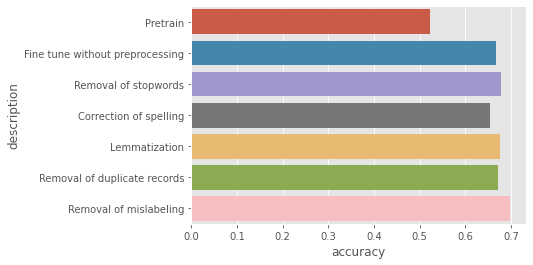

In [57]:
sns.barplot(data=df_acc, y="description", x="accuracy")

In [ ]:
error_data['duplicated']=error_data.duplicated(subset=['original_text'])
error_data_unique=error_data[error_data['duplicated']==False]

In [ ]:
error_data_unique

In [ ]:
# Create dataframe with corrected 
test_full=test_data_unique.merge(error_data_unique,how="left",left_on="original_text",right_on="original_text")
test_full['label_y']=test_full['label_y'].apply(lambda x: '1' if pd.isnull(x) else '0')
test_full['duplicated']=test_full.duplicated(subset=['original_text'])
test_full_unique=test_full[test_full['duplicated']==False]
test_full=pd.DataFrame(test_full[['original_text','label_x','label_y','duplicated','dulabel']])
test_full.columns=['original_text','label','correct','duplicated','dulabel']
test_full

In [ ]:
#test_full.to_csv("./00_error_analysis/test_full.csv",index=False)

In [ ]:
import matplotlib.pyplot as plt
# TRAIN SET 
test_full['original_text'].apply(lambda x: len(x.split())).plot(kind='hist');
plt.yscale('log');
plt.title('Distribution of original text length in words')

In [ ]:
error_data['original_text'].apply(lambda x: len(x.split())).describe()

In [ ]:
error_data

### Rerun the prediction to confirm the errors

In [ ]:
import pandas as pd

# import bert test error data
error_data_path="./tmp/test_error_2022-10-13.csv"
error_data=pd.read_csv(error_data_path)

# import bert full test data
test_data_path="./tmp/test_full_2022-10-13.csv"
test_data=pd.read_csv(test_data_path)

##### Import 2 models for comparison: fine tuning model, and pretrained model without fine tuning

In [ ]:

    target_names = list(set(test_full['label']))
    label2idx = {label: idx for idx, label in enumerate(target_names)}
    
    # Enable GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Select bert model
    BERT_MODEL = "distilbert-base-uncased"
    tokenizer = DistilBertTokenizer.from_pretrained(BERT_MODEL)
    
    # Using trained model
    model_state_dict = torch.load(os.path.join(OUTPUT_DIR, MODEL_FILE_NAME), map_location=lambda storage, loc: storage)
    model=DistilBertForSequenceClassification.from_pretrained(BERT_MODEL, state_dict=model_state_dict, num_labels = len(target_names),
                                                             output_attentions = False,
                                                             output_hidden_states = False)

In [ ]:
    # Select bert model
    BERT_MODEL = "distilbert-base-uncased"
    v_tokenizer = DistilBertTokenizer.from_pretrained(BERT_MODEL)
    
    # Using trained model
    v_model=DistilBertForSequenceClassification.from_pretrained(BERT_MODEL,num_labels = len(target_names),
                                                             output_attentions = False,
                                                             output_hidden_states = False)   

Check result on pretrained model

In [ ]:
#str_to_predict = "olawe"
str_to_predict = "He also worked extensively on animal behavior -LRB- ethology -RRB- ."

In [ ]:
features = convert_examples_to_inputs([str_to_predict],[1], label2idx, MAX_SEQ_LENGTH, v_tokenizer)

In [ ]:
v_tokenizer.tokenize(str_to_predict)

In [ ]:
inputs = v_tokenizer(str_to_predict, return_tensors="pt")

with torch.no_grad():
    logits = v_model(**inputs).logits

predicted_class_id = logits.argmax().item()
v_model.config.id2label[predicted_class_id]

In [ ]:
inputs

In [ ]:
import lime
import torch
import torch.nn.functional as F
from lime.lime_text import LimeTextExplainer

def predictor(texts):
    with torch.no_grad():
        outputs = v_model(**v_tokenizer(texts, return_tensors="pt", padding=True))
        #print(outputs.logits)
        probas = F.softmax(outputs.logits,dim=1).detach().numpy()
    return probas

explainer = LimeTextExplainer(class_names=target_names)


In [ ]:
exp = explainer.explain_instance(str_to_predict, predictor, num_features=200, num_samples=20)
exp.show_in_notebook(text=str_to_predict)

In [ ]:
from transformers_interpret import SequenceClassificationExplainer
cls_explainer = SequenceClassificationExplainer(
    v_model,
    v_tokenizer)
word_attributions = cls_explainer(str_to_predict)
word_attributions

 Check result on fine tuning model

In [ ]:
inputs = tokenizer(str_to_predict, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

predicted_class_id = logits.argmax().item()
model.config.id2label[predicted_class_id]

In [ ]:
def predictor(texts):
    with torch.no_grad():
        outputs = model(**tokenizer(texts, return_tensors="pt", padding=True))
        #print(outputs.logits)
        probas = F.softmax(outputs.logits,dim=1).detach().numpy()
    return probas

explainer = LimeTextExplainer(class_names=target_names)

In [ ]:
exp = explainer.explain_instance(str_to_predict, predictor, num_features=200, num_samples=20)
exp.show_in_notebook(text=str_to_predict)

The above presents the fine tuning process actually changed the prediction result. That could be caused by:
- The word is attributed to be difficultly understood.
- The similar words or sentence are trained as difficult one.

Thus, the next tasks are to confirm the aboves.

##### Sentencebert to find the similiar sentences to check whether the similiar sentences may impact the classifier.

In [ ]:
from sentence_transformers import SentenceTransformer
onlinemodel='all-mpnet-base-v2'
embedder = SentenceTransformer(onlinemodel)

In [ ]:
# load training data
train_data_path="./01_data/WikiLarge_Train.csv"
train_data=pd.read_csv(train_data_path)
texts=train_data['original_text']

In [ ]:
if os.path.exists("./tmp/embeddings.csv"):
    query_embeddings= np.loadtxt("./tmp/embeddings.csv", delimiter=",")
else:
    # Sampling data given the full train data volume is big
    query_embeddings=embedder.encode(texts)
    np.savetxt("./tmp/embeddings.csv", query_embeddings, delimiter=",")

In [ ]:
# work out the similarity and identify the record of self
from sklearn.metrics.pairwise import cosine_similarity
sim=cosine_similarity([embedder.encode(str_to_predict)],query_embeddings)
j=np.argmax(sim)
#sim.argsort()[-3:][::-1][0][:-1]

In [ ]:
# produce the fine tuning dataset
f_texts=[]
f_labels=[]
for i in np.where(sim[0]>0.7)[0]:
    if i!=j:
        f_texts.append(train_data.iloc[i]['original_text'])
        f_labels.append(train_data.iloc[i]['label'])
    #print(i,train_data.iloc[i]['label'].values,train_data.iloc[i]['original_text'].values,sim[0][i])
    

In [ ]:
f_texts

In [ ]:
f_labels.count(1),f_labels.count(0)

In [ ]:
f_labels

In [ ]:
f_labels=[1,0,0]

Fine tuning the pretrained model with the above similar data

In [ ]:
    # Select bert model
    BERT_MODEL = "distilbert-base-uncased"
    f_tokenizer = DistilBertTokenizer.from_pretrained(BERT_MODEL)
    
    # Using trained model
    f_model=DistilBertForSequenceClassification.from_pretrained(BERT_MODEL,num_labels = len(target_names),
                                                             output_attentions = False,
                                                             output_hidden_states = False)   

In [ ]:
# convert selected data into training set
f_features = convert_examples_to_inputs(f_texts,f_labels, label2idx, MAX_SEQ_LENGTH, f_tokenizer)
f_train_dataloader = get_data_loader(f_features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=True)

In [ ]:
from transformers import AdamW,get_linear_schedule_with_warmup

GRADIENT_ACCUMULATION_STEPS = 1
# Tuning in https://mccormickml.com/2019/07/22/BERT-fine-tuning/#41-bertforsequenceclassification
#NUM_TRAIN_EPOCHS = 20
NUM_TRAIN_EPOCHS = 8
#LEARNING_RATE = 5e-5
LEARNING_RATE = 1e-5
WARMUP_PROPORTION = 0.1
MAX_GRAD_NORM = 5

num_train_steps = int(len(f_train_dataloader.dataset) / BATCH_SIZE / GRADIENT_ACCUMULATION_STEPS * NUM_TRAIN_EPOCHS)
num_warmup_steps = 600 #int(WARMUP_PROPORTION * num_train_steps)

param_optimizer = list(f_model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

optimizer = AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE, correct_bias=False)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps,num_training_steps=num_train_steps)


In [ ]:
f_model.to(device)

In [ ]:
import os
from tqdm import trange
#from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, precision_recall_fscore_support

 # tuning guide:https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html
torch.backends.cudnn.benchmark = True

loss_history = []
no_improvement = 0
NUM_TRAIN_EPOCHS=8
for _ in trange(int(NUM_TRAIN_EPOCHS), desc="Epoch"):
    f_model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    
    for step, batch in enumerate(tqdm(f_train_dataloader, desc="Training iteration")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, label_ids = batch
        #outputs = model(input_ids, attention_mask=input_mask, token_type_ids=segment_ids, labels=label_ids)
        outputs = f_model(input_ids, attention_mask=input_mask,labels=label_ids)
        loss = outputs[0]

        if GRADIENT_ACCUMULATION_STEPS > 1:
            loss = loss / GRADIENT_ACCUMULATION_STEPS

        loss.backward()
        tr_loss += loss.item()

        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(f_model.parameters(), MAX_GRAD_NORM)  
            
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()

In [ ]:
# Confirm the error data should not be predicted correctly.
texts=[str_to_predict]
labels=[0]

In [ ]:

    # Enable GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    f_model.to(device)
    
    # Convert text and labels to embeddings 
    features = convert_examples_to_inputs(texts, labels, label2idx, MAX_SEQ_LENGTH, tokenizer)
    dataloader = get_data_loader(features, MAX_SEQ_LENGTH, BATCH_SIZE, shuffle=False)
    
    # Predict the result, and discard the evaluatoin result, only take the prediction result.
    _, correct, predicted = evaluate(f_model, dataloader)

In [ ]:
print(correct,predicted)

In [ ]:
f_model.to(device)

In [ ]:
f_inputs = f_tokenizer(str_to_predict, return_tensors="pt")

with torch.no_grad():
    f_logits = f_model(**f_inputs.to(device)).logits

predicted_class_id = f_logits.argmax().item()
f_model.config.id2label[predicted_class_id]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot histogram with the length. Truncate max length to 5000 tokens.
plt.style.use("ggplot")

plt.figure(figsize=(10, 8))
train_data['length'] = train_data['original_text'].apply(lambda x: len(x.split()))
sns.distplot(train_data[train_data['length'] < 5000]['length'])
plt.title('Frequence of documents of a given length', fontsize=14)
plt.xlabel('length', fontsize=14)

##### BERT-topic model

In [ ]:
from bertopic import BERTopic

from transformers.pipelines import pipeline

#sentence_model = SentenceTransformer("xlm-r-bert-base-nli-stsb-mean-tokens", device="cuda")
topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
#topics, probs = topic_model.fit_transform(train_data['original_text'])

In [ ]:
# topics for error data
err_topics, err_probs = topic_model.fit_transform(test_data['original_text'])

In [ ]:
error_data[error_data['original_text']=="olawe"]

In [ ]:
docs=error_data['original_text'].to_list()

In [ ]:
dir(topic_model)

In [ ]:
topic_model.get_topic_info()

In [ ]:
topic_model.visualize_distribution(probs[200], min_probability=0.015)

In [ ]:
topic_model.visualize_barchart(top_n_topics=5)

In [ ]:
topic_model.visualize_heatmap(n_clusters=20, width=1000, height=1000)

In [ ]:
# Look for sentences with similiar words count
width=0
df_range=train_data[train_data['length']<=train_data.iloc[j]['length']+width].reset_index()

In [ ]:
len(df_range)

In [ ]:
embedding_range=embedder.encode(df_range['original_text'])

In [ ]:
# Clustering algorithms
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics.pairwise import cosine_similarity

# Elbow criterion - Determine optimal numbers of clusters by elbow rule.
def elbow_plot(data, maxK=15, seed_centroids=None):
    """
        parameters:
        - data: pandas DataFrame (data to be fitted)
        - maxK (default = 10): integer (maximum number of clusters with which to run k-means)
        - seed_centroids (default = None ): float (initial value of centroids for k-means)
    """
    sse = []
    K= range(1, maxK)
    for k in K:
        if seed_centroids is not None:
            seeds = seed_centroids.head(k)
            kmeans = KMeans(n_clusters=k, max_iter=500, n_init=100, random_state=0, init=np.reshape(seeds, (k,1))).fit(data)
            #data["clusters"] = kmeans.labels_
        else:
            kmeans = KMeans(n_clusters=k, max_iter=300, n_init=100, random_state=0).fit(data)
            #data["clusters"] = kmeans.labels_
        print("k: ", k,"sse: ",kmeans.inertia_)
        # Inertia: Sum of distances of samples to their closest cluster center
        sse.append(kmeans.inertia_)
    plt.figure()
    plt.plot(K,sse,'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()
    return kmeans.labels_

In [ ]:
# Run Elbow for full training data
elbow_plot(embedding_range,maxK=10)

In [ ]:
num_clusters = 2
clf = KMeans(n_clusters=num_clusters, 
            max_iter=100, 
            init='k-means++', 
            n_init=1)
clf.fit_predict(embedding_range)
cluster_assignment = clf.labels_

cdf=pd.DataFrame(columns=["cluster_id","sentence_id","sentence"])

for i in range(len(cluster_assignment)):
    new_row=pd.Series(data={"cluster_id":cluster_assignment[i],
                                "sentence_id":df_range.iloc[i]['index'],
                                "sentence":df_range.iloc[i]['original_text']
                           }
                            )
    cdf=cdf.append(new_row,ignore_index=True)

cdf.head()

In [ ]:
cdf

In [ ]:
# Using PCA to reduce the dimension to project the result to 2-d scatter plot
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(embedding_range)

df_pca = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

df_pca['sentence_id']=df_range['index']
# Combine PCA results with K-means results to see clustering
df_k=df_pca.merge(cdf,right_on=['sentence_id'],left_on=['sentence_id'])

In [ ]:
len(df_k)

In [ ]:
fig, ax = plt.subplots()
ls_clusters=pd.unique(df_k["cluster_id"])
#ls_colors=df_k["cluster_id"].astype('category').cat.codes
for id in range(len(ls_clusters)):
    ax.scatter(df_k[df_k['cluster_id']==ls_clusters[id]]['principal component 1'],
               df_k[df_k['cluster_id']==ls_clusters[id]]['principal component 2'],label=ls_clusters[id],
               alpha=0.3, edgecolors='none')

ax.legend()
ax.grid(True)

plt.show()

In [ ]:
len(df_k[df_k['cluster_id']==0])

#### Spelling error correction

In [ ]:
# correct spelling error to check whether accuracy could be improved.
#from textblob import TextBlob
#error_data['correct_text_0'] = error_data['original_text'].apply(lambda x :TextBlob(x).correct())

In [ ]:
from autocorrect import Speller
import re

spell=Speller(lang="en")
WORD = re.compile(r'\w+')
def reTokenize(doc):
    tokens = WORD.findall(doc)
    return tokens

text = ["Hi, welcmoe to speling.","This is jsut an exapmle, but cosnider a veri big coprus."]
def spell_correct(text):
    sptext = []
    for doc in text:
        sptext.append(' '.join([spell(w).lower() for w in reTokenize(doc)]))      
    return sptext    

print(spell_correct(text)) 

In [ ]:
from tqdm import trange
correct_text=[]
for i in trange(len(error_data)):
    correct_text.append(TextBlob(error_data['original_text'].iloc[i]).correct())
error_data['correct_text_0'] = correct_text

In [ ]:
from tqdm import trange
correct_text=[]
for i in trange(len(error_data)):
    correct_text.append(' '.join([spell(w).lower() for w in reTokenize(error_data['original_text'].iloc[i])]))
error_data['correct_text_1'] = correct_text

In [ ]:
texts=list(error_data["correct_text_0"])
labels=list(error_data["label"])
data_evaluation(texts,labels)

In [ ]:
error_data

In [ ]:
texts=list(error_data["correct_text_1"])
labels=list(error_data["label"])
data_evaluation(texts,labels)

##### The above result suggests spelling check could improve 13% accuracy, however, the performance of spelling check is not encouraging.

In [ ]:
#error_data.to_csv("./tmp/error_data_20221006.csv",index=False) # export error data to csv for manual check

#### Clean text to see whether that would improve accuracy

In [ ]:
texts=list(error_data["clean_text"])
labels=list(error_data["label"])
data_evaluation(texts,labels)

In [ ]:
from text_preprocessing import preprocess_text
from text_preprocessing import to_lower, remove_punctuation,remove_special_character,normalize_unicode,check_spelling,remove_stopword,lemmatize_word
# Preprocess text using custom preprocess functions in the pipeline 
STOPWORDS=['-RRB-','-LRB-'] # remove customized stopwords
preprocess_functions = [to_lower, remove_punctuation,remove_special_character,normalize_unicode,remove_stopword,lemmatize_word]
error_data['preprocess_text'] = error_data['correct_text_1'].apply(lambda x:' '.join(remove_stopword(preprocess_text(x,preprocess_functions),
                                                                                          stop_words=STOPWORDS)))

In [ ]:
error_data

In [ ]:
texts=list(error_data["preprocess_text"])
labels=list(error_data["label"])
data_evaluation(texts,labels)

#### The accuracy of error list was improved to 34%, and it looks like the preprocessing text do help to improve accuracy. 

In [ ]:
train_data_path="./01_data/WikiLarge_Train.csv"
train_data=pd.read_csv(train_data_path)

In [ ]:
correct_text=[]
for i in trange(len(train_data)):
    correct_text.append(' '.join([spell(w).lower() for w in reTokenize(train_data['original_text'].iloc[i])]))
train_data['correct_text_1'] = correct_text

In [ ]:
train_data.to_csv("./tmp/train_data_correction.csv",index=False)

##### Given the above improvement, and try to apply this to test set

In [ ]:
# Loading the test data for submission
sub_data_path="./01_data/WikiLarge_Test.csv"
sub_data=pd.read_csv(sub_data_path)

In [ ]:
correct_text=[]
for i in trange(len(sub_data)):
    correct_text.append(' '.join([spell(w).lower() for w in reTokenize(sub_data['original_text'].iloc[i])]))
sub_data['correct_text_1'] = correct_text

In [ ]:
#sub_data['original_text'] = sub_data['correct_text_1'].apply(lambda x:' '.join(remove_stopword(preprocess_text(x,preprocess_functions),
#                                                                                          stop_words=STOPWORDS)))

In [ ]:
sub_data.to_csv("./tmp/sub_data_correction.csv",index=False)

In [ ]:
sub_texts=list(sub_data["correct_text_1"])
sub_labels=[1 for i in range(len(sub_texts))]

print("Submission Test size:", len(sub_data))

In [ ]:
_, sub_predicted=data_evaluation(sub_texts,sub_labels)

In [ ]:
# Produce the submission file
df_sub=pd.DataFrame(columns=["id","label"])
df_sub['label']=sub_predicted
df_sub['id']=[i for i in range(len(sub_predicted))]
df_sub.to_csv("./tmp/submission.csv",index=False)

### Embedding-based clustering analysis

In [ ]:
# Other utils
from tqdm import tqdm  # Progress bar
# Transformers
from transformers import pipeline
import ipywidgets as widgets
from transformers import pipeline
from sentence_transformers import SentenceTransformer

In [ ]:
#onlinemodel='distiluse-base-multilingual-cased-v2'
onlinemodel="all-mpnet-base-v2"
embedder = SentenceTransformer(onlinemodel)

In [ ]:
queries= list(error_data['original_text'])
query_embeddings=embedder.encode(queries)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Elbow criterion - Determine optimal numbers of clusters by elbow rule.
def elbow_plot(data, maxK=15, seed_centroids=None):
    """
        parameters:
        - data: pandas DataFrame (data to be fitted)
        - maxK (default = 10): integer (maximum number of clusters with which to run k-means)
        - seed_centroids (default = None ): float (initial value of centroids for k-means)
    """
    sse = []
    K= range(1, maxK)
    for k in K:
        if seed_centroids is not None:
            seeds = seed_centroids.head(k)
            kmeans = KMeans(n_clusters=k, max_iter=500, n_init=100, random_state=0, init=np.reshape(seeds, (k,1))).fit(data)
            #data["clusters"] = kmeans.labels_
        else:
            kmeans = KMeans(n_clusters=k, max_iter=300, n_init=100, random_state=0).fit(data)
            #data["clusters"] = kmeans.labels_
        print("k: ", k,"sse: ",kmeans.inertia_)
        # Inertia: Sum of distances of samples to their closest cluster center
        sse.append(kmeans.inertia_)
    plt.figure()
    plt.plot(K,sse,'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()
    return kmeans.labels_

In [ ]:
# Run Elbow for full training data
elbow_plot(query_embeddings)

In [ ]:
# Create clustering dataframe 
def df_clustering(queries, embeddings, labels=None, clusters=2):
    """
        parameters:
        - queries: list of queries
        - embeddings: list of embeddings corresponding to queries
        - clusters: no. of clusters for kmeans
    """
    num_clusters = clusters
    clf = KMeans(n_clusters=num_clusters, 
                max_iter=100, 
                init='k-means++', 
                n_init=1)
    clf.fit_predict(embeddings)
    cluster_assignment = clf.labels_

    cdf=pd.DataFrame(columns=["cluster_id","sentence_id","sentence",'label'])

    cdf['cluster_id']=clf.labels_
    cdf['sentence_id']=[i for i in range(len(clf.labels_))]
    cdf['sentence']=queries
    cdf['label']=labels
                                            
    return cdf

In [ ]:
num_clusters = 4
clf = KMeans(n_clusters=num_clusters, 
            max_iter=100, 
            init='k-means++', 
            n_init=1)
clf.fit_predict(query_embeddings)
cluster_assignment = clf.labels_

cdf=pd.DataFrame(columns=["cluster_id","sentence_id","sentence"])

for i in range(len(cluster_assignment)):
    new_row=pd.DataFrame({"cluster_id":[cluster_assignment[i]],
                                "sentence_id":[i],
                                "sentence":[queries[i]]
                           })
    cdf=pd.concat([cdf,new_row],axis=0,ignore_index=True)

cdf.head()

In [ ]:
# Using PCA to reduce the dimension to project the result to 2-d scatter plot
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(query_embeddings)

df_pca = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

df_pca['sentence']=queries
# Combine PCA results with K-means results to see clustering
df_k=df_pca.merge(cdf,right_on=['sentence'],left_on=['sentence'])

In [ ]:
fig, ax = plt.subplots()
ls_clusters=pd.unique(df_k["cluster_id"])
ls_colors=['tab:blue', 'tab:orange', 'tab:green','tab:purple']
#ls_colors=df_k["cluster_id"].astype('category').cat.codes
for id in range(len(ls_clusters)):
    ax.scatter(df_k[df_k['cluster_id']==ls_clusters[id]]['principal component 1'],
               df_k[df_k['cluster_id']==ls_clusters[id]]['principal component 2'], c=ls_colors[id], label=ls_clusters[id],
               alpha=0.9, edgecolors='none')

ax.legend()
ax.grid(True)

plt.show()